In [76]:
import tensorflow as tf
from tensorflow import keras

print('TensorFlow version:',tf.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.8.0
Keras version: 2.8.0


### We first want to use the txt files with files paths to copy our files into a new directory

In [77]:
import os
from pathlib import Path

WD_PATH = os.getcwd()
PARENT_PATH = os.path.dirname(WD_PATH)
DATA_PATH = os.path.join(PARENT_PATH, "Data")

GRS_Txt = os.path.join(DATA_PATH, "Grey_Reef_Shark_Keep")
GRS_Txt = os.path.join(GRS_Txt, "keep_images.txt")

BTRS_Txt = os.path.join(DATA_PATH, "Blacktip_Reef_Shark_Keep")
BTRS_Txt = os.path.join(BTRS_Txt, "keep_images.txt")

BTS_Txt = os.path.join(DATA_PATH, "Blacktip_Shark_Keep")
BTS_Txt = os.path.join(BTS_Txt, "keep_images.txt")

WTRS_Txt = os.path.join(DATA_PATH, "Whitetip_Reef_Shark_Keep")
WTRS_Txt = os.path.join(WTRS_Txt, "keep_images.txt")


In [87]:
import numpy as np
import cv2

GRS_paths = np.loadtxt(GRS_Txt, dtype=str)
BTRS_paths = np.loadtxt(BTRS_Txt, dtype=str)
BTS_paths = np.loadtxt(BTS_Txt, dtype=str)
WTRS_paths = np.loadtxt(WTRS_Txt, dtype=str)

for i, path in enumerate(GRS_paths):
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(DATA_PATH, f"Images\\GRS_Images\\GRS_Image_{i}.png"), image)

for i, path in enumerate(BTRS_paths):
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(DATA_PATH, f"Images\\BTRS_Images\\BTRS_Image_{i}.png"), image)

for i, path in enumerate(BTS_paths):
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(DATA_PATH, f"Images\\BTS_Images\\BTS_Image_{i}.png"), image)

for i, path in enumerate(WTRS_paths):
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(DATA_PATH, f"Images\\WTRS_Images\\WTRS_Image_{i}.png"), image)

### Now we want to get our training, validation, and test datasets

In [118]:
img_size = (256, 256)
batch_size = 16

train_data_dir = "C:\\Users\\ks121\\OneDrive\\Documents\\Coding\\Shark_Identification\\Data\\Images"
test_data_dir = "C:\\Users\\ks121\\OneDrive\\Documents\\Coding\\Shark_Identification\\Data\\Images_Test"

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 1617 files belonging to 4 classes.
Using 1294 files for training.
Found 1617 files belonging to 4 classes.
Using 323 files for validation.
Found 200 files belonging to 4 classes.


In [102]:
class_names = test_ds.class_names
print(class_names)

['BTRS_Images', 'BTS_Images', 'GRS_Images', 'WTRS_Images']


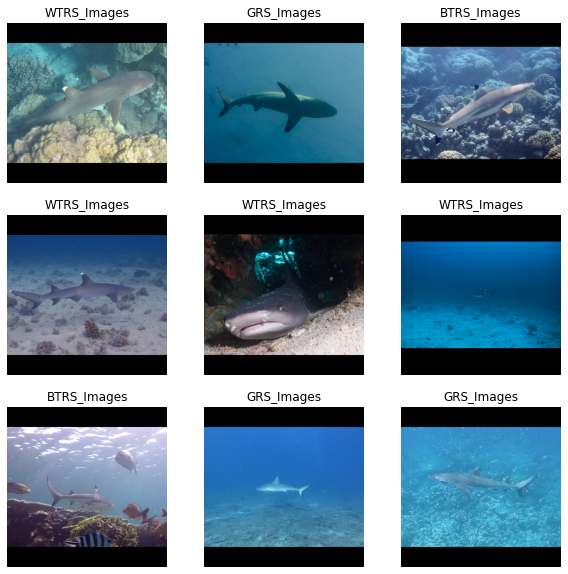

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [105]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 500, 500, 3)
(16,)


In [119]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.2), 
            layers.experimental.preprocessing.RandomZoom(0.2) 
        ]
    )

    inputs = layers.Input(shape=(256,256,3))
    x = data_augmentation(inputs)

    filters_0 = 16

    x = layers.experimental.preprocessing.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=filters_0, kernel_size=5, use_bias=False)(x)

    filters = [32, 64, 128, 256]
    for size in filters:
        residual = x
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation("LeakyReLU")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Activation("LeakyReLU")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

        x = layers.MaxPooling2D((2,2), strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
        x = layers.add([x,residual])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.55)(x)
    outputs = layers.Dense(1, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [113]:
#Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [122]:
with strategy.scope():
    model = build_model()
    model.summary()
    learning_rate = 1e-6
    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CatsvsDogs_op_test_16_deeper.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks
)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 252, 252, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 252, 252, 3)  0           ['input_16[0][0]']               
                                                                                                  
 rescaling_15 (Rescaling)       (None, 252, 252, 3)  0           ['sequential_15[0][0]']          
                                                                                                  
 conv2d_75 (Conv2D)             (None, 248, 248, 16  1200        ['rescaling_15[0][0]']    

KeyboardInterrupt: 